#### QB presentation figure making round-2:

We use the templete function testing code to create figures for QB in-house presentation. 

1. shaded testable regions
2. color coded error distribution



In [1]:
import graph_create, voronoi_local, jaccard_similarity, figure_plot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import networkx as nx

from scipy.stats import mannwhitneyu
from scipy.spatial import Voronoi

-----

## Read in the graph

We read in the vein network and the dots as a combined graph object, with the single dots in non overlapping faces highlighted in orange.

In [2]:
sample = 'PileaTLeaf2'
dot_folder= 'dot_images'
vein_folder= 'vein_graphs'

G = graph_create.graph_creation(sample, dot_folder, vein_folder)

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.



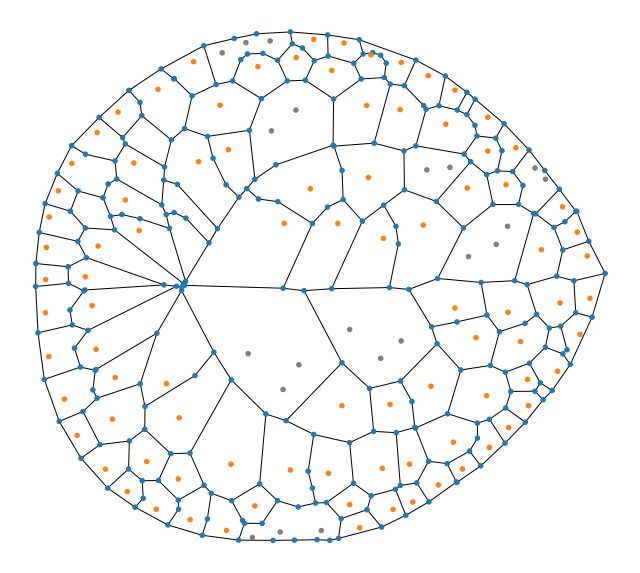

In [3]:
figure_plot.quick_plot(G)

-----

## Perform local tests

For the "one face - one dot" dots, we locally test the voronoi properties between it and other eligible dots in the adjacent faces. We ask whether the line segment connecting two dots is perpendicualar to the shared edges of the face, and whether their distance to the edge is the same.

In [4]:
# local tests:
adj_faces_mat, shared_edges_mat = voronoi_local.shared_edges(G, threshold = 50)
rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat,G.graph['dots_passed'], G, dot_bool = True)
rst[2]

,mean angle error,std angle error,mean distance error,std distance error
0,8.380696,6.707946,0.264142,0.223166


We use the centroid dots and random dots in the face as baselines for the local test.

In [5]:
# baseline local tests:
cent_in_faces, mid_in_faces, rand_in_faces = voronoi_local.random_n_centroid(G)

In [6]:
centroid_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat, cent_in_faces)
midpoint_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat ,mid_in_faces)
random_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat, rand_in_faces)

-----

## Visualize local test

we color the dual edges (by connecting dots) to represent test performance.

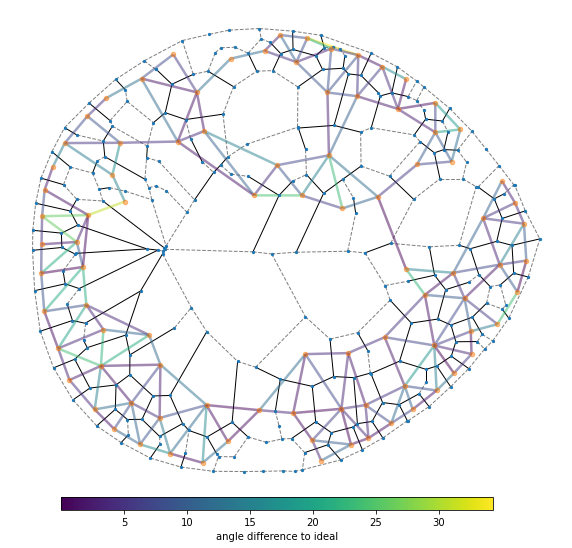

In [7]:
G_dual = graph_create.make_dual(G, cent_in_faces, mid_in_faces, rand_in_faces, rst[0])
figure_plot.plot_dual(G, G_dual, attr = "angle")

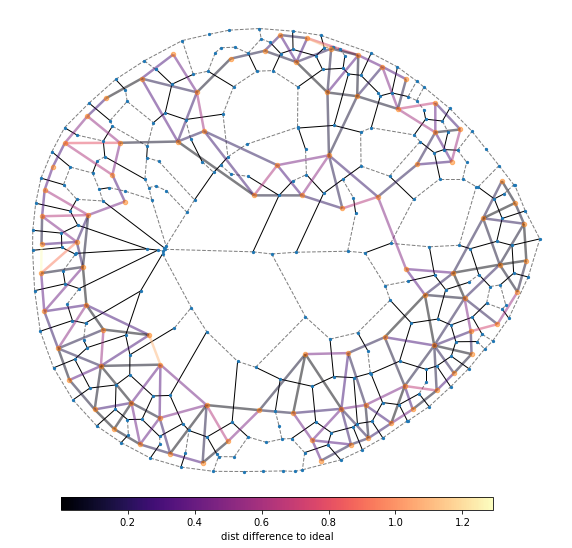

In [8]:
figure_plot.plot_dual(G, G_dual, attr = "dist")

-------
## Visualize baseline

We plot location of the baseline nodes (centroids in purple, random in red) in comparsion to that of the dots.

In [9]:
def plot_baseline_dot_only(G, G_dual):
    '''
    quick plotting for graph and dual  
    '''
    node_position_G = {}
    
    # compared_position_dual = {}
    node_position_dual = {}
                                                                                                        
    for node in G.nodes:
        node_position_G[node] = node
    
    for node in G_dual.nodes:
        # compared_position_dual[node] = (G_dual.nodes[node][pt_type][0], G_dual.nodes[node][pt_type][1])
        node_position_dual[node] = node
     
    #color_dict = {'centroid': 'red', 'midpoint': 'deeppink','random':'purple'}  
    
    fig, ax = plt.subplots(figsize=(9,9/G.graph['ratio']))
    
    # later might need two colors for two ind of nodes, dk if networkx do it automatically 
    nx.draw_networkx_edges(G, 
            pos=node_position_G, 
            edge_color = 'C7', ax = ax) 
    nx.draw_networkx_nodes(G_dual, 
                           pos = node_position_dual,  
                           node_size = 20,
                           node_color = 'C1')
  
    ax.set_title('just dots for overlay', fontsize = 16)
    plt.tight_layout()
    plt.show()
    
    
    # 
    # fig.savefig(f'baseline_dot_only.pdf')

    return 

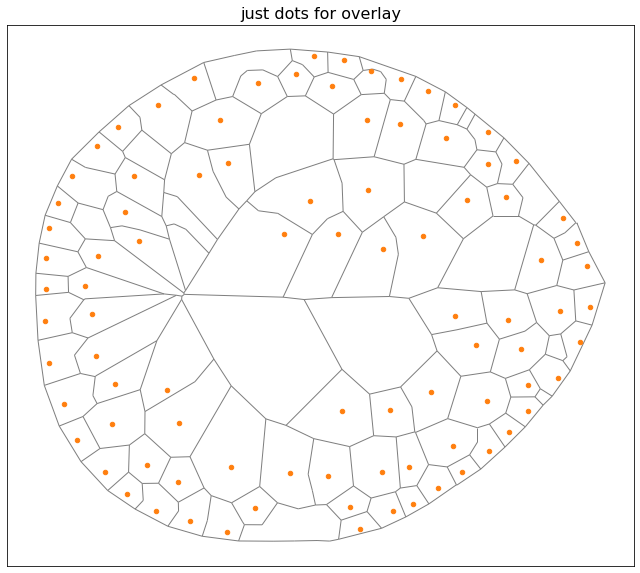

In [10]:
plot_baseline_dot_only(G, G_dual)

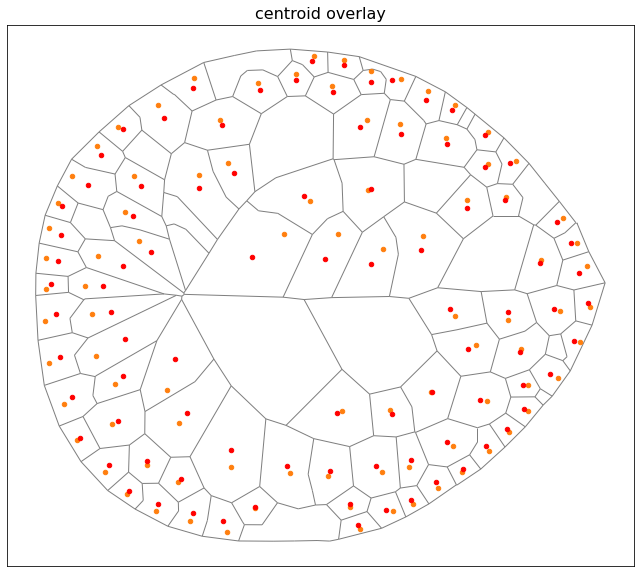

In [11]:
figure_plot.plot_baseline(G, G_dual, pt_type = 'centroid')

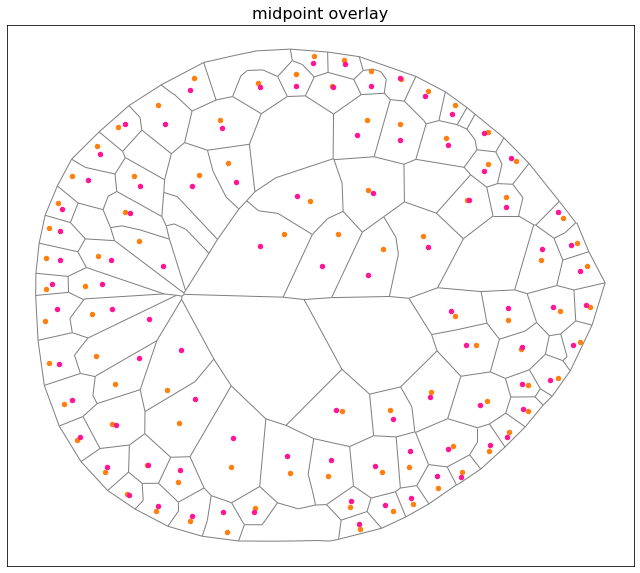

In [12]:
figure_plot.plot_baseline(G, G_dual, pt_type = 'midpoint')

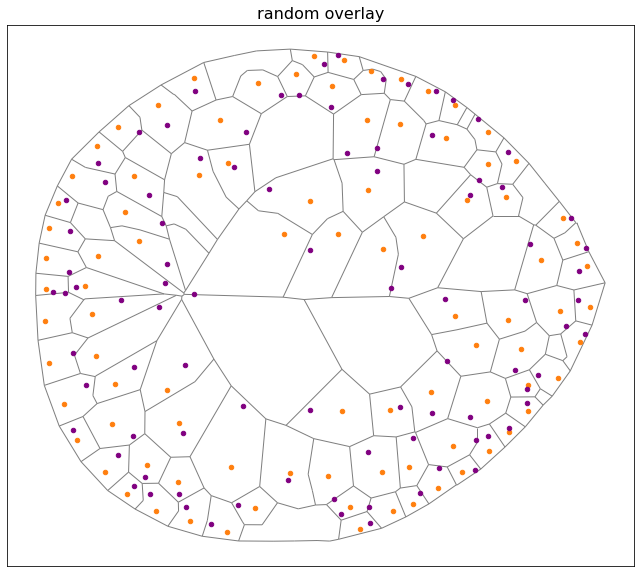

In [13]:
figure_plot.plot_baseline(G, G_dual, pt_type = 'random')

-------
## Statistically compare dot-pair performance in all passed faces

In [14]:
# combine local test results:
rst_df = rst[1]
rst_df['type'] = 'hydathode'
cent_df = centroid_rst[1]
cent_df['type'] = 'centroid'
mid_df = midpoint_rst[1]
mid_df['type'] = 'midpoint'
rand_df = random_rst[1]
rand_df['type'] = 'random'

df = pd.concat([rst_df, cent_df, mid_df, rand_df])

In [15]:
_, p_angle = mannwhitneyu(random_rst[1]['angle_diff'], rst[1]['angle_diff'])
_, p_dist = mannwhitneyu(random_rst[1]['dist_diff'], rst[1]['dist_diff'])

print('Mann Whitney U test result for angle error (random v.s. dot):', p_angle)
print('Mann Whitney U test result for percent distance error:', p_dist)


Mann Whitney U test result for angle error (random v.s. dot): 1.744198077154309e-17
Mann Whitney U test result for percent distance error: 1.2573544207531239e-28


In [16]:
_, p_angle = mannwhitneyu(midpoint_rst[1]['angle_diff'], rst[1]['angle_diff'])
_, p_dist = mannwhitneyu(midpoint_rst[1]['dist_diff'], rst[1]['dist_diff'])

print('Mann Whitney U test result for angle error (random v.s. dot):', p_angle)
print('Mann Whitney U test result for percent distance error:', p_dist)

Mann Whitney U test result for angle error (random v.s. dot): 1.4480709855249036e-06
Mann Whitney U test result for percent distance error: 2.025589328969009e-06


In [17]:
_, p_angle = mannwhitneyu(centroid_rst[1]['angle_diff'], rst[1]['angle_diff'])
_, p_dist = mannwhitneyu(centroid_rst[1]['dist_diff'], rst[1]['dist_diff'])

print('Mann Whitney U test result for angle error (random v.s. dot):', p_angle)
print('Mann Whitney U test result for percent distance error:', p_dist)

Mann Whitney U test result for angle error (random v.s. dot): 0.031487557239627345
Mann Whitney U test result for percent distance error: 0.007698517296114541


------
## Plot distributions of errors

We plot the local test result distributions.

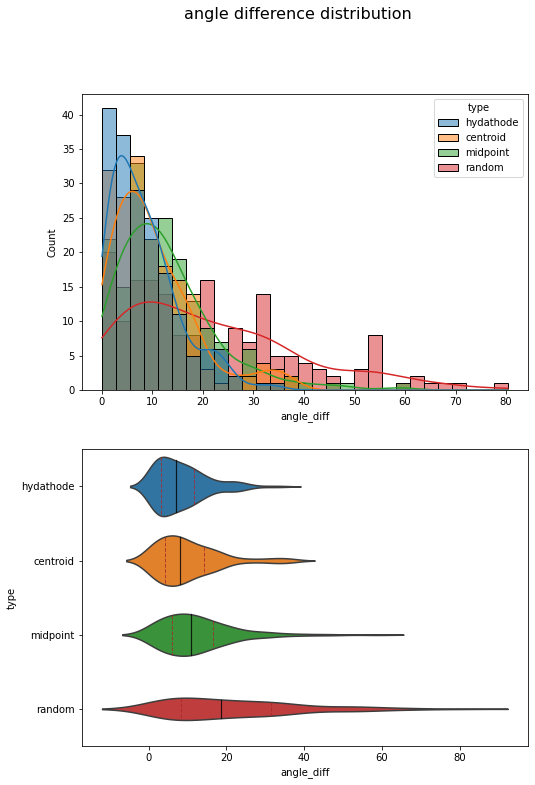

In [18]:
df.reset_index(level=0, inplace=True)

figure_plot.plot_dist(df, test = 'angle')

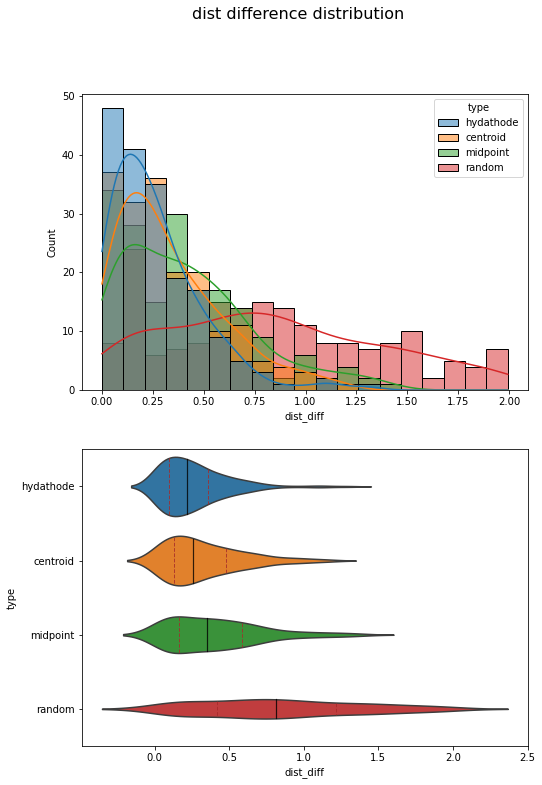

In [19]:
figure_plot.plot_dist(df, test = 'dist')

In [20]:
df

,index,angle_diff,dist_diff,type
0,0,6.216283,1.291966,hydathode
1,1,21.154174,0.940535,hydathode
2,2,8.569301,0.354510,hydathode
3,3,0.134818,0.083914,hydathode
4,4,2.452549,0.290713,hydathode
...,...,...,...,...
719,176,62.949604,1.044231,random
720,177,36.186710,1.052047,random
721,178,15.600941,0.527011,random
722,179,0.474408,0.772467,random


-------
## Visualize Voronoi Overlay

Plot voronoi diagram generated by the dots as seeds. Later we'll perform area overlap test for faces.

In [21]:
seeds = [n for n in G.nodes if G.nodes[n]['type'] != 'vein']
vor = Voronoi(seeds)

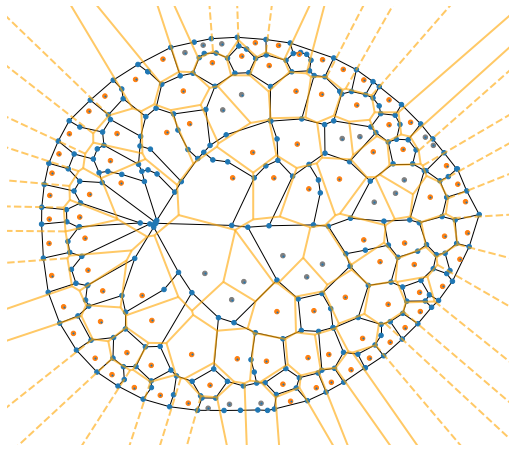

In [22]:
figure_plot.plot_voronoi(G, vor)

In [23]:
baseline_summary = pd.DataFrame(np.array([rst[2].iloc[0].tolist(), centroid_rst[2].iloc[0].tolist(), midpoint_rst[2].iloc[0].tolist(), random_rst[2].iloc[0].tolist()]), 
                                    columns = ['angle_mean', 'angle_std', 'dist_mean', 'dist_std'],
                                    index = ['dot', 'centroid', 'midpoint','random'])

In [24]:
baseline_summary

,angle_mean,angle_std,dist_mean,dist_std
dot,8.380696,6.707946,0.264142,0.223166
centroid,10.125135,8.245539,0.331264,0.259851
midpoint,12.585426,9.609237,0.410281,0.314734
random,21.749214,16.955343,0.843022,0.529214


-------
### Visualize where dots perform less well compared to centroid:

In [25]:
dual_edge_list = []
M = len(shared_edges_mat)
for i in range(M):
    node1 = G.graph['dots_passed'][i]
    for j in range(i+1, M):
        # if they are adjacent:
        if adj_faces_mat[i][j]:
            node2 = G.graph['dots_passed'][j]
            dual_edge_list.append((node1, node2))

G_dual_bad_angles = graph_create.create_dual_subgraph(G_dual, rst_df, cent_df, dual_edge_list,  attr = 'angle')
G_dual_bad_dists = graph_create.create_dual_subgraph(G_dual, rst_df, cent_df, dual_edge_list, attr = 'dist')


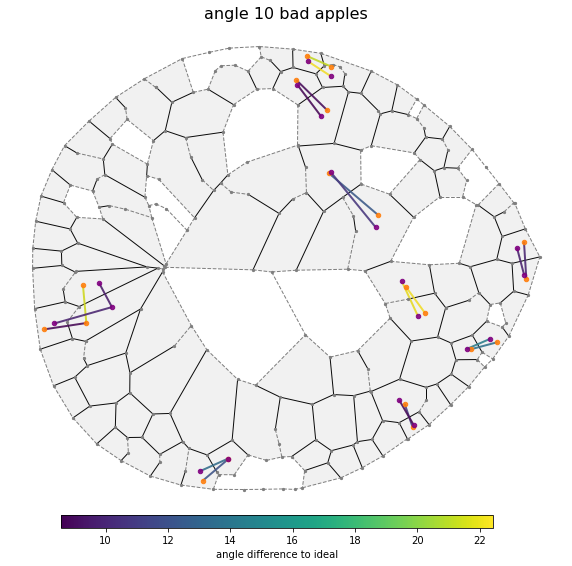

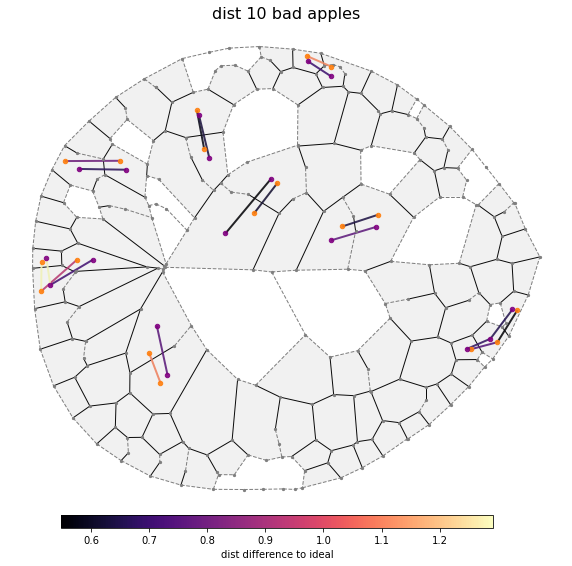

In [26]:
figure_plot.plot_subdual(G, G_dual_bad_angles, attr = "angle")
figure_plot.plot_subdual(G, G_dual_bad_dists, attr = "dist")

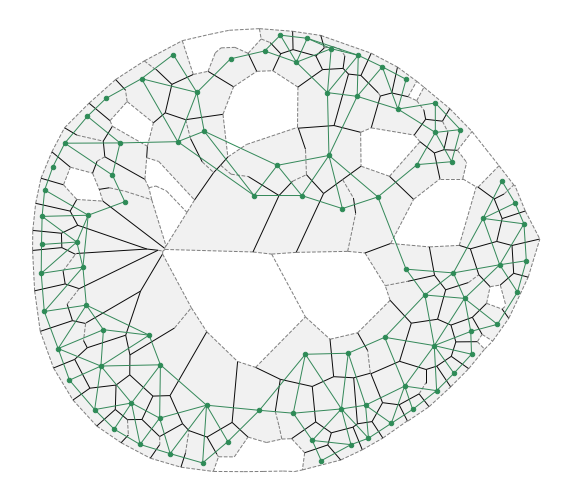

In [27]:
# plot shaded polygons:

node_position_G = {}
    
node_position_dual = {}


for node in G.nodes:
    node_position_G[node] = node

edge_style = ['solid' if G.edges[e]['shared'] =='tested_shared' else 'dashed' for e in G.edges]
edge_col = ['black' if G.edges[e]['shared'] =='tested_shared' else 'C7' for e in G.edges]

for node in G_dual.nodes:
    node_position_dual[node] = node

fig, ax = plt.subplots(figsize=(10,10/G.graph['ratio']))

for i in range(len(G.graph['faces_passed'])):
    p = mpl.patches.Polygon(G.graph['faces_passed'][i], facecolor = 'C7', alpha = .1)
    ax.add_patch(p)

nx.draw_networkx_edges(G, pos=node_position_G, edge_color = edge_col, style = edge_style, ax = ax) 

nx.draw(G_dual, pos=node_position_dual, node_size= 20,  node_color= 'seagreen', 
        edge_color ='seagreen',  width = 1, ax = ax)


  
plt.show()   

# fig.savefig('shaded_poly.pdf', dpi = 300)

-------------

### Perform area test

In [28]:
seeds = [n for n in G.nodes if G.nodes[n]['type'] != 'vein']
vor = Voronoi(seeds)
bounded_regions = jaccard_similarity.bounded_polygons(G, vor)
J_list = jaccard_similarity.overlap_test(G, seeds, bounded_regions, type = 'dot')

In [29]:
centroid_seeds, midpoint_seeds, random_seeds = jaccard_similarity.hybrid_seeds(G)

centroid_vor = Voronoi(centroid_seeds)
midpoint_vor =  Voronoi(midpoint_seeds)
random_vor = Voronoi(random_seeds)

centroid_bounded_regions = jaccard_similarity.bounded_polygons(G, centroid_vor)
midpoint_bounded_regions = jaccard_similarity.bounded_polygons(G, midpoint_vor)
random_bounded_regions = jaccard_similarity.bounded_polygons(G, random_vor)

centroid_J_list = jaccard_similarity.overlap_test(G, seeds, centroid_bounded_regions, type = 'centroid')
midpoint_J_list = jaccard_similarity.overlap_test(G, seeds, midpoint_bounded_regions, type = 'midpoint')
random_J_list = jaccard_similarity.overlap_test(G, seeds, random_bounded_regions, type = 'random')

J_df = pd.DataFrame(np.array([J_list, centroid_J_list, midpoint_J_list, random_J_list ]).T, columns = ['dots', 'centroid', 'midpoint', 'random'])

J_df.head()


,dots,centroid,midpoint,random
0,0.574379,0.712459,0.731789,0.567515
1,0.577096,0.592104,0.624394,0.320156
2,0.617267,0.570301,0.613601,0.306050
3,0.689141,0.762550,0.735559,0.442861
4,0.689476,0.744619,0.662318,0.431116


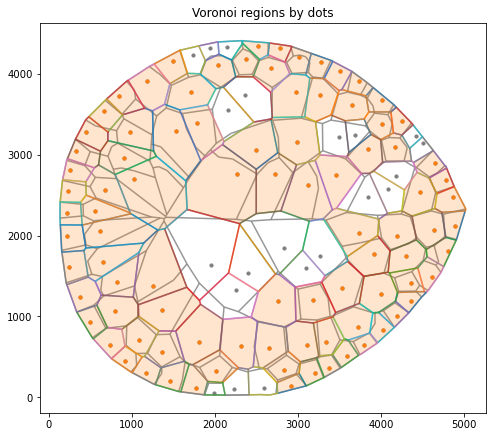

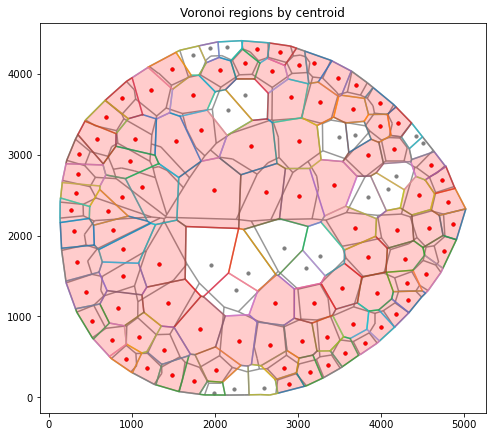

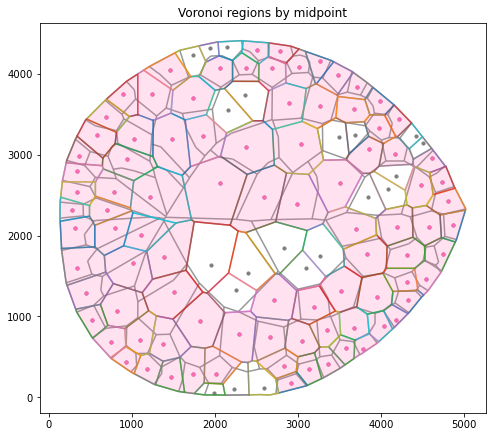

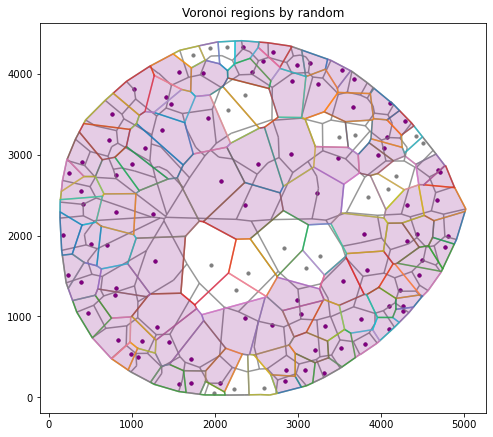

In [30]:
single_dot = [G.nodes[seed]['type'] == 'single_dot' for seed in seeds]

figure_plot.plot_vor_regions(G, seeds, single_dot, bounded_regions, dot_type = 'dots')
figure_plot.plot_vor_regions(G, centroid_seeds, single_dot, centroid_bounded_regions, dot_type = 'centroid')
figure_plot.plot_vor_regions(G, midpoint_seeds, single_dot, midpoint_bounded_regions, dot_type = 'midpoint')
figure_plot.plot_vor_regions(G, random_seeds, single_dot, random_bounded_regions, dot_type = 'random')

### Added 05/14: plot overlap diff

In [31]:
def plot_overlap_diff(type = 'dot', bounded_regions = bounded_regions, seeds = seeds):
    fig, ax = plt.subplots(figsize = (8, 8/G.graph['ratio']))

    node_positions = {}

    for node in G.nodes:
        node_positions[node] = node

    dot_color = {'dot':'C1', 'centroid':'red','midpoint': 'hotpink', 'random':'purple'}
    color = dot_color[type]

    # plot veins:     
    nx.draw_networkx_edges(G, pos=node_positions, edge_color = 'C7', ax = ax, width = 1.5, alpha = .8) 

    # plot voronoi polygons:
    for i in range(len(bounded_regions)):
        ax.plot(np.array(bounded_regions[i])[:,0], np.array(bounded_regions[i])[:,1], alpha = .7, color = 'C7') # change color to grey

    # plot diff patches:
    for geom in G.graph[f'diff_geom_{type}']:  

        if isinstance(geom, shapely.geometry.polygon.Polygon):
            contour = list(geom.exterior.coords)
           
            if len(contour):
                p = mpl.patches.Polygon(contour, facecolor = color, alpha = .3)
                ax.add_patch(p)
                
            if len(list(geom.interiors)):
                interior = list(geom.interiors[0].coords)
                p_in = mpl.patches.Polygon(contour, facecolor = 'white', alpha = 1)
                ax.add_patch(p_in)
                
        else: # multipolygon.MultiPolygon
            for ploy in geom:
                contour = list(ploy.exterior.coords)
                if len(contour):
                    p = mpl.patches.Polygon(contour, facecolor = color, alpha = .3)
                    ax.add_patch(p)

                    
                if len(list(ploy.interiors)):
                    interior = list(ploy.interiors[0].coords)
                    p_in = mpl.patches.Polygon(interior, facecolor = 'white', alpha = 1)
                    ax.add_patch(p_in)
    
    # plot seeds:
    ax.scatter(np.array(seeds)[:,0], np.array(seeds)[:,1], s = 10, c = 'C7')

    for i in range(len(bounded_regions)):
        if single_dot[i]:
            ax.scatter(seeds[i][0], seeds[i][1], s = 10, c = dot_color[type])


    plt.show()

    fig.savefig(f'{type}_overlap_diff.pdf')

        

<ipython-input-31-2b3cb0d0311e>:35: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for ploy in geom:


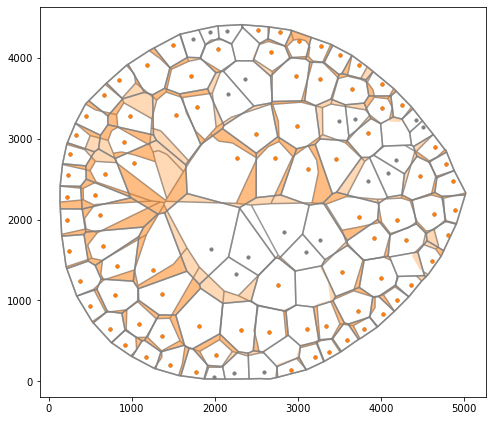

<ipython-input-31-2b3cb0d0311e>:35: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for ploy in geom:


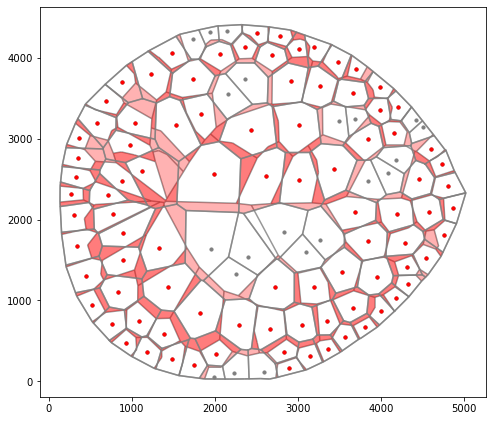

<ipython-input-31-2b3cb0d0311e>:35: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for ploy in geom:


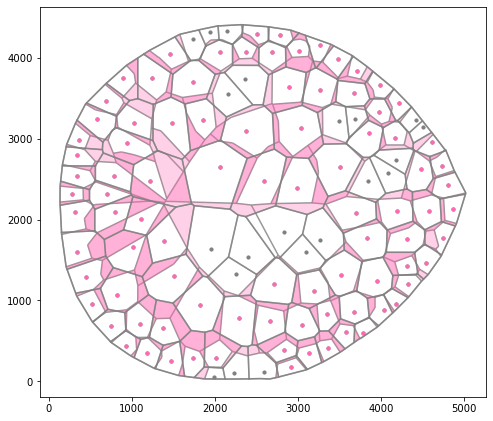

<ipython-input-31-2b3cb0d0311e>:35: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for ploy in geom:


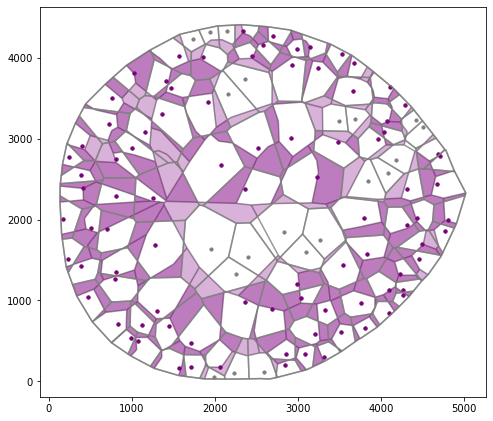

In [32]:
plot_overlap_diff('dot')
plot_overlap_diff('centroid', bounded_regions= centroid_bounded_regions, seeds = centroid_seeds)
plot_overlap_diff('midpoint', bounded_regions= midpoint_bounded_regions, seeds = midpoint_seeds)
plot_overlap_diff('random', bounded_regions = random_bounded_regions, seeds = random_seeds)

In [33]:
def plot_dist_color_coded(df, test = 'dist'):

    fig, ax = plt.subplots(nrows =2, figsize = (8, 10))
    colors = ['orange','red', 'deeppink', 'purple']
    sns.set_palette(sns.color_palette(colors))
    sns.histplot(df, x = 'angle_diff', hue = 'type', alpha = .3, kde = True,
                ax = ax[0] )
    
    ax[0].set_title(f'{test} error distribution', fontsize = 24)
    ax[0].set_xlabel('')
    ax[0].set_ylabel('count', fontsize = 20)
    # ax[0].legend(loc='upper right', fontsize=20) 
    plt.setp(ax[0].get_legend().get_texts(), fontsize='14') # for legend text
    plt.setp(ax[0].get_legend().get_title(), fontsize='16') # for legend title
    
    ax[1] = sns.boxplot(x = f'{test}_diff', y = 'type' , 
                            data = df, width = .5, boxprops=dict(alpha=.8))

    # ax[1] = sns.violinplot(x = f'{test}_diff', y = 'type' , 
    #                         data = df, inner = 'quartile')
    # for l in ax[1].lines:
    #     l.set_linestyle('--')
    #     l.set_linewidth(1)
    #     l.set_color('royalblue')
    #     l.set_alpha(0.8)
    # for l in ax[1].lines[1::3]:
    #     l.set_linestyle('-')
    #     l.set_linewidth(1.2)
    #     l.set_color('black')
    #     l.set_alpha(0.8)

    ax[1].set_xlabel(f'{test} error', fontsize = 20)
    ax[1].set_ylabel('', fontsize = 20)
    ax[1].tick_params(axis='y', size= 20)

    # fig.suptitle(f'{test} difference distribution', fontsize = 16)

    fig.tight_layout() # no they overlaps
    plt.show()

    # fig.savefig(f'{test}_distribution.pdf', dpi = 300)

    return

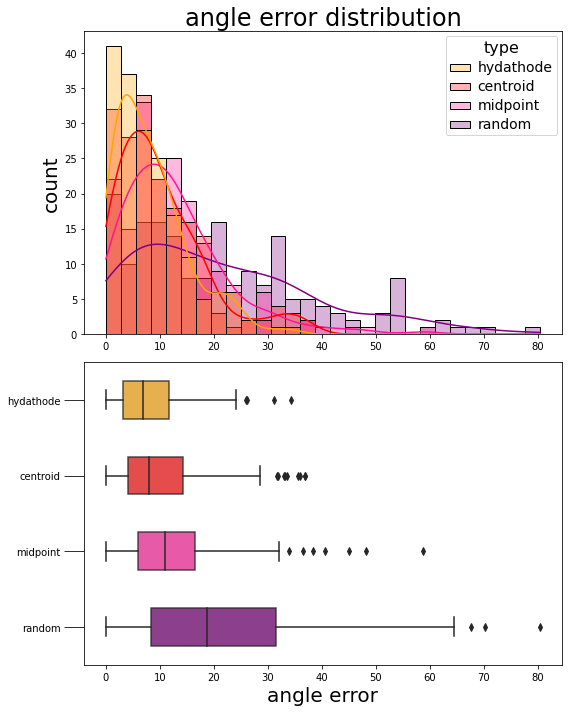

In [34]:
df.reset_index(level=0, inplace=True)

plot_dist_color_coded(df, test = 'angle')

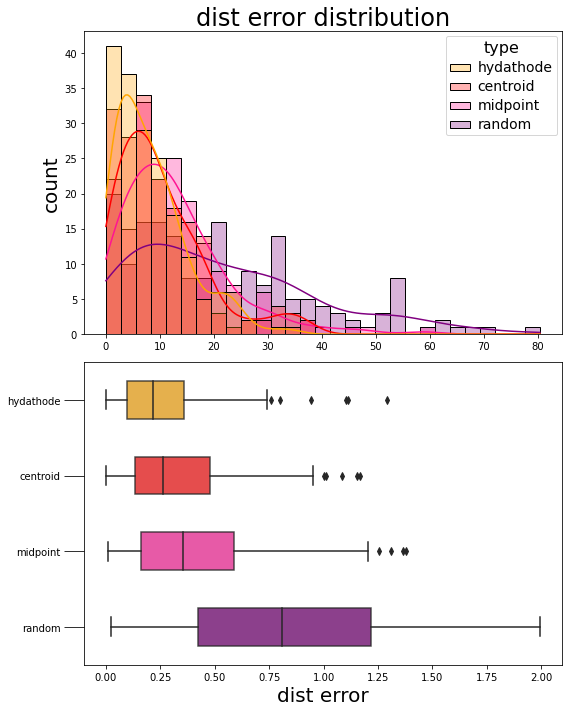

In [35]:
plot_dist_color_coded(df, test = 'dist')

In [36]:
rst_df.describe()

,angle_diff,dist_diff
count,181.000000,181.000000
mean,8.380696,0.264142
std,6.707946,0.223166
min,0.015040,0.001175
25%,3.267817,0.098216
50%,6.955204,0.218469
75%,11.704980,0.360450
max,34.339087,1.291966


In [37]:
rst_df

,angle_diff,dist_diff,type
0,6.216283,1.291966,hydathode
1,21.154174,0.940535,hydathode
2,8.569301,0.354510,hydathode
3,0.134818,0.083914,hydathode
4,2.452549,0.290713,hydathode
...,...,...,...
176,5.493004,0.006751,hydathode
177,4.100820,0.089396,hydathode
178,9.865456,0.016190,hydathode
179,2.654443,0.043310,hydathode
